In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_lstm_att, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
STATE = 'GO'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

In [5]:
LOSS = 'mse'

In [6]:
batch_size = 4
model = build_lstm_att( hidden=64, features=8, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = 'relu')

model 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (4, 89, 8)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (4, 89, 8)        │         65 │ input_layer[0][0] │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (4, 89, 8)        │          0 │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (4, 89, 16)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (4, 64)           │     20,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (4, 64)           │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (4, 52)           │      3,380 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,181 (94.46 KB)

 Trainable params: 24,181 (94.46 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [8]:
epochs = 1000

In [9]:
TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=epochs,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )


Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0735 - loss: 0.0397 - mape: 1943171.7500 - mse: 0.0302 - val_accuracy: 0.0222 - val_loss: 0.0345 - val_mape: 50175.7383 - val_mse: 0.0250
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1386 - loss: 0.0300 - mape: 770965.2500 - mse: 0.0205 - val_accuracy: 0.0444 - val_loss: 0.0327 - val_mape: 58894.6602 - val_mse: 0.0233
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0972 - loss: 0.0299 - mape: 457007.8750 - mse: 0.0205 - val_accuracy: 0.1111 - val_loss: 0.0318 - val_mape: 21269.5117 - val_mse: 0.0225
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1293 - loss: 0.0326 - mape: 685669.8125 - mse: 0.0233 - val_accuracy: 0.0667 - val_loss: 0.0307 - val_mape: 9206.4258 - val_mse: 0.0215
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0501 - loss: 0.0296 - mape: 270161.3750 - mse: 0.0203 - val_accuracy: 0.0889 - val_loss: 0.0292 - val_mape: 23660.369

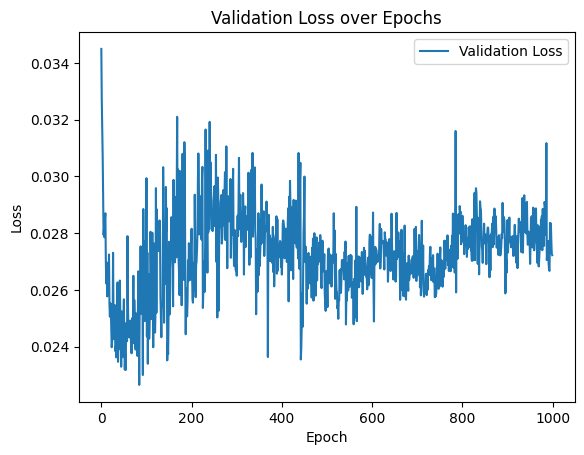

In [10]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [11]:
model_name = 'att'
columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                           'peak_week', 'perc_geocode']

In [12]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_23 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_23['adm_1'] = STATE
df_preds_23['adm_0'] = 'BR'
df_preds_23['adm_2'] = pd.NA

df_preds_23.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 2min, sys: 373 ms, total: 2min
Wall time: 2min


In [13]:
df_23_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_23_base.dates = pd.to_datetime(df_23_base.dates)
df_23_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,368.110187,475.790924,561.944483,GO,BR,NaN
1,2022-10-16,79.776429,229.481860,418.222873,GO,BR,NaN
2,2022-10-23,211.502896,430.462600,594.140599,GO,BR,NaN
3,2022-10-30,383.457976,489.500468,610.915553,GO,BR,NaN
4,2022-11-06,549.379481,661.474994,800.468128,GO,BR,NaN


In [14]:
df_preds_23.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,408.387554,498.841049,566.361134,GO,BR,<NA>
1,2022-10-16,395.382490,485.182458,561.073714,GO,BR,<NA>
2,2022-10-23,379.591719,445.955154,533.621560,GO,BR,<NA>
3,2022-10-30,420.790191,483.407290,548.322308,GO,BR,<NA>
4,2022-11-06,529.205048,583.065995,660.457519,GO,BR,<NA>


In [15]:
data_w = df[['casos']].resample('W-SUN').sum()

data_w.head()

,casos
date,
2010-01-03,5554
2010-01-10,6930
2010-01-17,7175
2010-01-24,7317
2010-01-31,7286


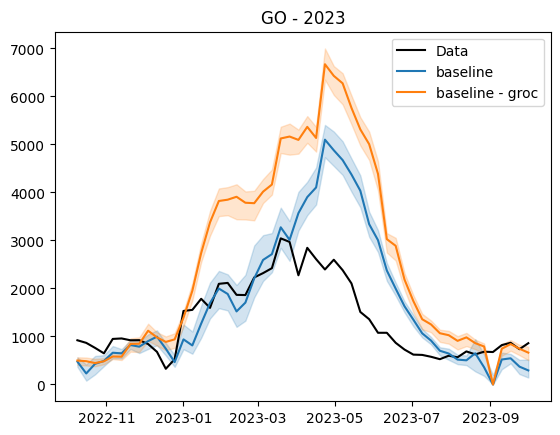

In [16]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_23_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_23_base.dates, df_23_base.preds, label ='baseline')
ax.fill_between(df_23_base.dates, df_23_base.lower, df_23_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_23.dates, df_preds_23.preds, label ='baseline - groc')

ax.fill_between(df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()

### Training the model for 2024:

In [17]:
from keras.models import load_model

model = load_model(f'./saved_models/model_groc_{STATE}_2022_{model_name}.keras')

In [18]:
TEST_YEAR = 2024

In [19]:
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [20]:
hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=1000,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3058 - loss: 0.0149 - mape: 361947.2812 - mse: 0.0061 - val_accuracy: 0.1400 - val_loss: 0.0211 - val_mape: 501844.6250 - val_mse: 0.0123
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2134 - loss: 0.0212 - mape: 454449.2500 - mse: 0.0124 - val_accuracy: 0.1800 - val_loss: 0.0201 - val_mape: 630722.1875 - val_mse: 0.0113
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3195 - loss: 0.0152 - mape: 411005.2812 - mse: 0.0064 - val_accuracy: 0.1600 - val_loss: 0.0197 - val_mape: 717063.1250 - val_mse: 0.0109
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2331 - loss: 0.0131 - mape: 348671.7812 - mse: 0.0043 - val_accuracy: 0.1600 - val_loss: 0.0207 - val_mape: 605965.0000 - val_mse: 0.0119
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3402 - loss: 0.0128 - mape: 598269.2500 - mse: 0.0040 - val_accuracy: 0.2000 - val_loss: 0.0177 - val_mape: 41115

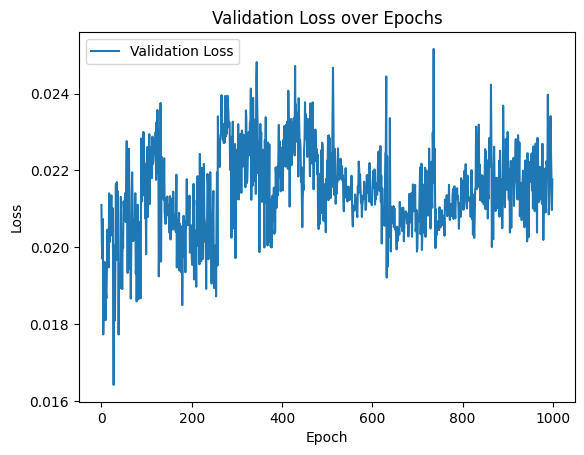

In [21]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

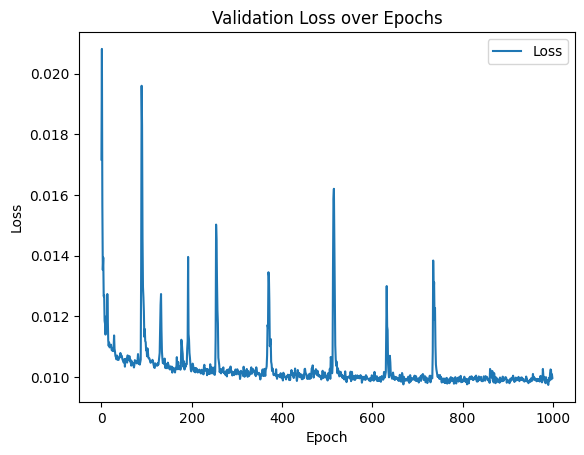

In [22]:
plt.figure()
plt.plot(hist.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [23]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_24 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_24['adm_1'] = STATE
df_preds_24['adm_0'] = 'BR'
df_preds_24['adm_2'] = pd.NA

df_preds_24.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 2min 3s, sys: 524 ms, total: 2min 3s
Wall time: 2min 4s


In [24]:
df_24_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_24_base.dates = pd.to_datetime(df_24_base.dates)
df_24_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2023-10-08,1152.701268,1464.255913,1858.861114,GO,BR,NaN
1,2023-10-15,543.923998,895.518478,1305.715412,GO,BR,NaN
2,2023-10-22,890.006103,1165.777309,1519.070973,GO,BR,NaN
3,2023-10-29,1328.879444,1582.374816,1917.500133,GO,BR,NaN
4,2023-11-05,2287.813942,2713.683444,3272.191824,GO,BR,NaN


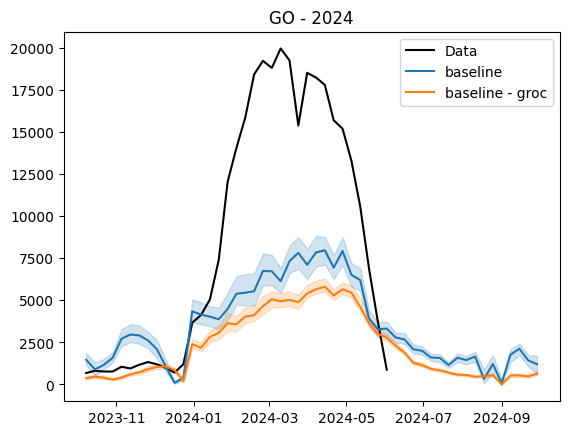

In [25]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_24_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_24_base.dates, df_24_base.preds, label ='baseline')
ax.fill_between(df_24_base.dates, df_24_base.lower, df_24_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_24.dates, df_preds_24.preds, label ='baseline - groc')

ax.fill_between(df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()